In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os

import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory

from tensorflow.keras.applications import DenseNet121
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,MaxPooling2D , Conv2D,Flatten
from tensorflow.keras.models import Sequential

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import classification_report


from IPython.display import clear_output
import warnings
warnings.filterwarnings('ignore')

In [51]:
SEED = 12
IMG_HEIGHT = 64
IMG_WIDTH = 64
BATCH_SIZE = 64
EPOCHS = 100
LR =  0.00003

In [ ]:
import os
base_dir = os.getcwd()  

train_dir = os.path.join(base_dir, 'BTP_Dataset', 'Train')
test_dir=os.path.join(base_dir,'BTP_Dataset','Test')

In [ ]:
crime_types = os.listdir(train_dir)
crime_types = [item for item in crime_types if not item.startswith('.')]  
n = len(crime_types) 
print('Number of crime categories:',n)

Number of crime categories: 14


In [57]:
crimes={}
train=test=0
for clss in crime_types:
    num=len(os.listdir(os.path.join(train_dir,clss)))
    train+=num
    test+=len(os.listdir(os.path.join(test_dir,clss)))
    
    crimes[clss]=num

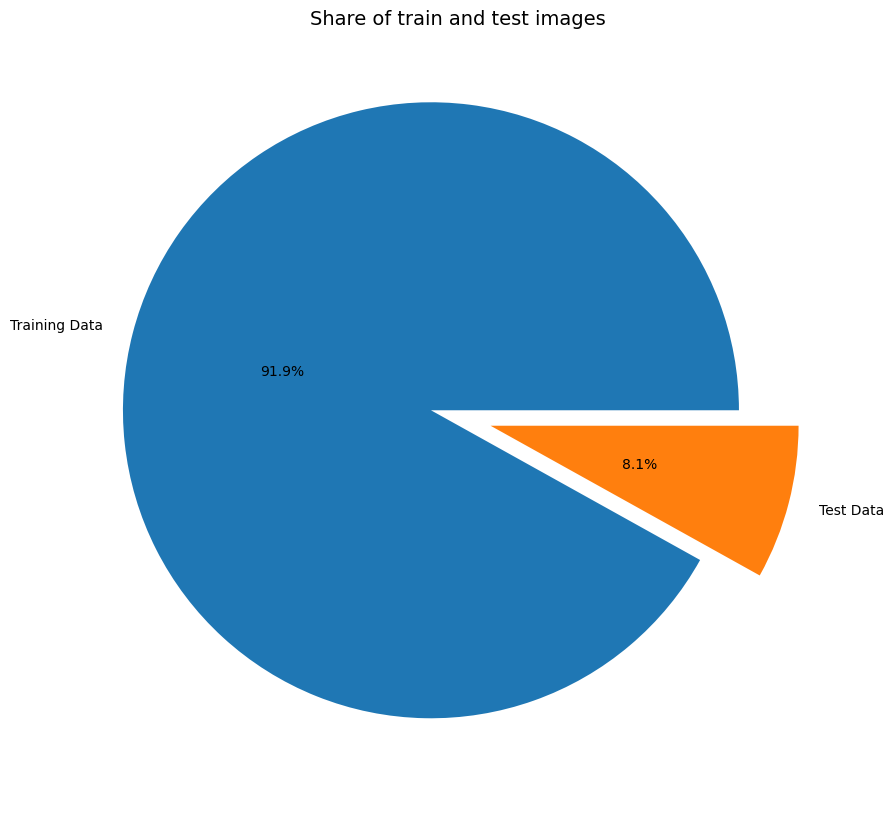

In [59]:
plt.figure(figsize=(15, 10))
plt.pie(x=np.array([train,test]), autopct="%.1f%%", explode=[0.1, 0.1], labels=["Training Data", "Test Data"], pctdistance=0.5)
plt.title("Share of train and test images ", fontsize=14);

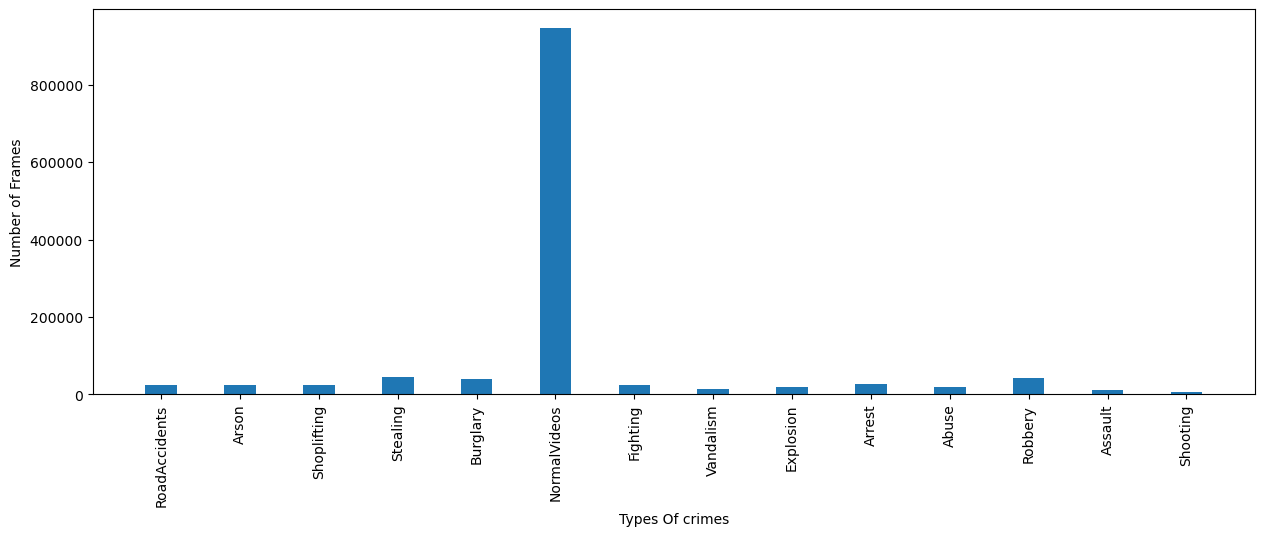

In [77]:
plt.figure(figsize=(15,5))
plt.bar(list(crimes.keys()), list(crimes.values()), width=0.4,align="center" )
plt.xticks(rotation=90)

plt.xlabel('Types Of crimes')
plt.ylabel('Number of Frames')
plt.show()

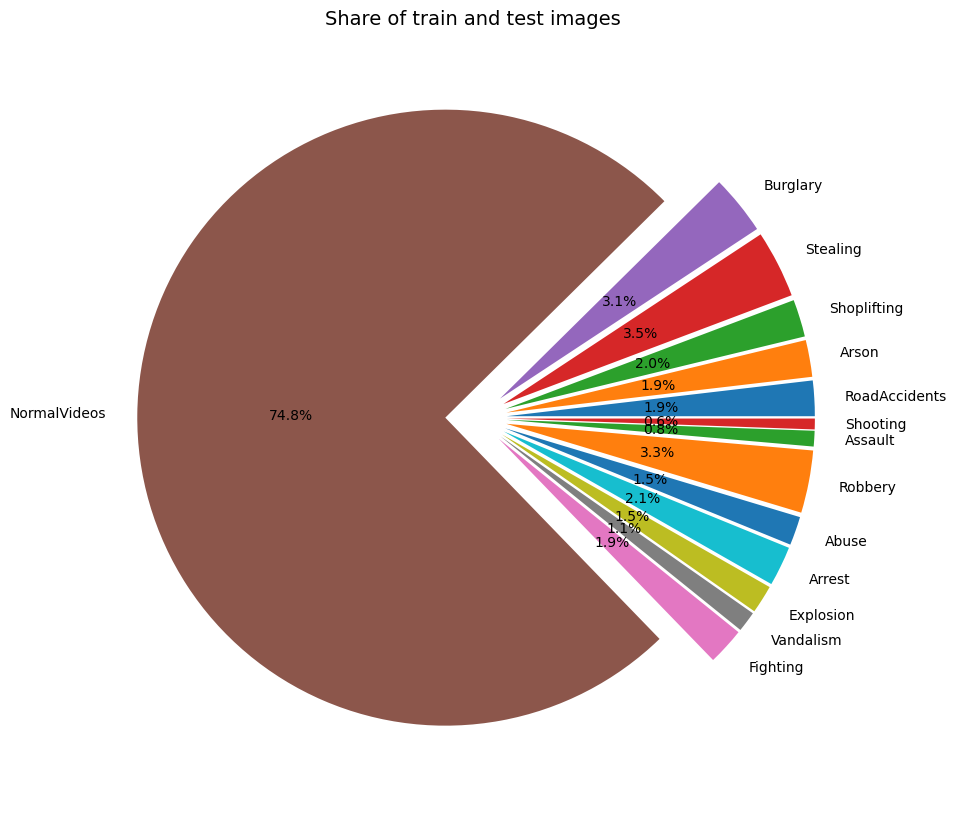

In [101]:
plt.figure(figsize=(15,10))
plt.pie(x=np.array(list(crimes.values())), autopct="%.1f%%", explode=[0.1]*n,labels=list(crimes.keys()), pctdistance=0.5)
plt.title("Share of train and test images ", fontsize=14);

In [103]:
IMG_WIDTH=64
IMG_HEIGHT=64

IMG_SHAPE=(IMG_HEIGHT,IMG_WIDTH)
seed=69

INPUT_SHAPE=(IMG_HEIGHT,IMG_WIDTH,3)

In [105]:
train_set=image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="training",
)

val_set=image_dataset_from_directory(
    train_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="validation",
)

test_set=image_dataset_from_directory(
    test_dir,
    label_mode="categorical",
    class_names=None,
    batch_size=BATCH_SIZE,
    image_size=IMG_SHAPE,
    shuffle=False,
    seed=seed,
)


Found 1266345 files belonging to 14 classes.
Using 1013076 files for training.
Found 1266345 files belonging to 14 classes.
Using 253269 files for validation.
Found 111308 files belonging to 14 classes.


In [107]:
def transfer_learning():
    base_model=DenseNet121(include_top=False,input_shape=INPUT_SHAPE,weights="imagenet")
    
    thr=149
    for layers in base_model.layers[:thr]:
        layers.trainable=False
    
    for layers in base_model.layers[thr:]:
        layers.trainable=True
    
    return base_model

In [109]:
def create_model():
    model=Sequential()
    
    base_model=transfer_learning()
    model.add(base_model)
    
    model.add(GlobalAveragePooling2D())
    
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.2))
    
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.2))
    
    model.add(Dense(1024, activation="relu"))
    
    model.add(Dense(n,activation="softmax",name="classification"))
    
    model.summary()
    
    return model

In [111]:
model=create_model()

model.compile(optimizer="adam", 
                loss='categorical_crossentropy',
                metrics = [tf.keras.metrics.AUC()])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 2, 2, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classification (Dense)          │ (None, 14)             │        14,350 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,971,150 (30.41 MB)

 Trainable params: 6,386,894 (24.36 MB)

 Non-trainable params: 1,584,256 (6.04 MB)

In [113]:
history = model.fit(x = train_set,validation_data=val_set,epochs = EPOCHS)

15830/15830 ━━━━━━━━━━━━━━━━━━━━ 37275s 2s/step - auc_1: 0.9950 - loss: 0.2145 - val_auc_1: 0.9996 - val_loss: 0.0325


In [241]:

model.save("crime_detection_model.h5")


In [245]:
from tensorflow.keras.models import load_model

model = load_model("crime_detection_model.h5")
model.compile(optimizer="adam", 
              loss="categorical_crossentropy", 
              metrics=[tf.keras.metrics.AUC()])

In [114]:
y_true =  np.array([])

for x, y in test_set:
  y_true = np.concatenate([y_true, np.argmax(y.numpy(), axis=-1)])

In [117]:
y_pred=model.predict(test_set)

1740/1740 ━━━━━━━━━━━━━━━━━━━━ 329s 188ms/step


In [211]:
y_pred

array([[0.05868914, 0.10515115, 0.03980106, ..., 0.00471524, 0.03815673,
        0.02749196],
       [0.01371102, 0.11728644, 0.03518283, ..., 0.00372971, 0.036208  ,
        0.01448016],
       [0.03369777, 0.16469665, 0.05176465, ..., 0.00545487, 0.01753848,
        0.01254513],
       ...,
       [0.00503548, 0.05103012, 0.30029777, ..., 0.0014955 , 0.04615825,
        0.03196296],
       [0.0034888 , 0.03726459, 0.435807  , ..., 0.00090644, 0.04765404,
        0.02708211],
       [0.00427906, 0.06484776, 0.13358468, ..., 0.00158592, 0.03203557,
        0.03665697]], dtype=float32)

In [213]:
y_true

array([ 0.,  0.,  0., ..., 13., 13., 13.])

In [215]:
def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    for (idx, c_label) in enumerate(crime_types):
        fpr, tpr, thresholds = roc_curve(y_test[:,idx].astype(int), y_pred[:,idx])
        c_ax.plot(fpr, tpr,lw=2, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'black',linestyle='dashed', lw=4, label = 'Random Guessing')
    return roc_auc_score(y_test, y_pred, average=average)

ROC AUC score: 0.8115658142171275


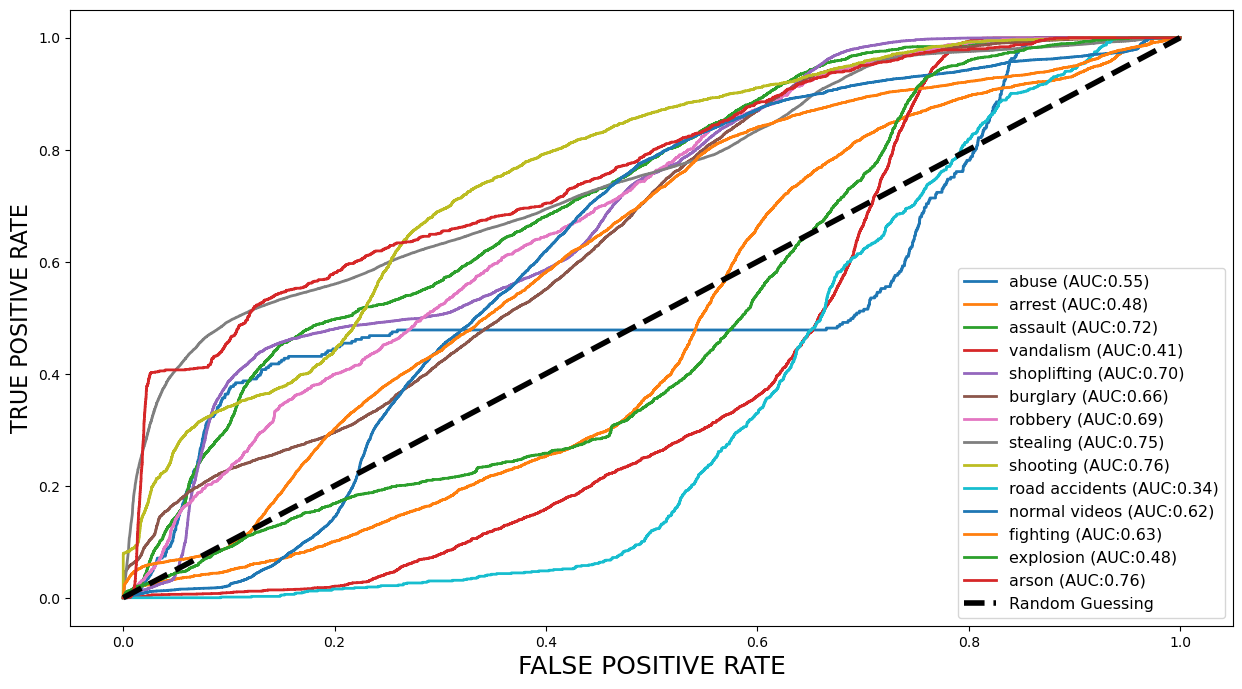

In [247]:
fig, c_ax = plt.subplots(1,1, figsize = (15,8))


print('ROC AUC score: ', multiclass_roc_auc_score(y_true , y_pred  , average = "micro"))
plt.xlabel('FALSE POSITIVE RATE', fontsize=18)
plt.ylabel('TRUE POSITIVE RATE', fontsize=16)
plt.legend(fontsize = 11.5)
plt.show()

In [148]:
!pip install --upgrade opencv-python


In [ ]:
from keras.models import load_model
import numpy as np
import cv2

# Load the trained model
model = load_model('crime_detection_model.h5')


labels = ['Robbery','Shoplifting','Fighting','NormalVedios','RoadAccidents', 'Burglary', 'Arson', 'Stealing','Assault', 'Arrest', 'Explosion',
         'Shooting', 'Vandalism','Abuse']

def preprocess_video(video_path, resize=(64, 64)):
    cap = cv2.VideoCapture(video_path)
    
    ret, frame = cap.read()
    if not ret:
        print("Failed to read video.")
        return None
    
    # Resize the frame
    frame = cv2.resize(frame, resize)
    
    cap.release()
    
    # Normalize and expand dimensions to match model input shape
    return np.expand_dims(frame / 255.0, axis=0)  # Shape will be (1, 64, 64, 3)

# Predict function
def predict_crime(video_path):
    preprocessed_video = preprocess_video(video_path)
    
    if preprocessed_video is None:
        return 
    
    predictions = model.predict(preprocessed_video)
    predicted_class = np.argmax(predictions, axis=1)[0]
    
    # Check if predicted_class is within the range of labels
    if predicted_class < len(labels):
        print(f"Predicted Class: {labels[predicted_class]}")
    else:
        print(f"Predicted class index {predicted_class} is out of range for labels.")


video_path = '/Users/choll/Download/AdobeStock_252303418_Video_HD_Preview.mp4'  
predict_crime(video_path)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 895ms/step
Predicted Class: Assault


In [ ]:
from keras.models import load_model
import numpy as np
import cv2

# Load the trained model
model = load_model('crime_detection_model.h5')

# Define labels (make sure these match the labels you used in training)
labels = ['Robbery','Assualt','Fighting','NormalVedios','RoadAccidents', 'Burglary', 'Arson', 'Shoplifting','Stealing', 'Arrest', 'Explosion',
         'Shooting', 'Vandalism','Abuse']  # Update as per your dataset

def preprocess_video(video_path, resize=(64, 64)):
    cap = cv2.VideoCapture(video_path)
    
    # Read only the first frame for prediction
    ret, frame = cap.read()
    if not ret:
        print("Failed to read video.")
        return None
    
    # Resize the frame
    frame = cv2.resize(frame, resize)
    
    cap.release()
    
    # Normalize and expand dimensions to match model input shape
    return np.expand_dims(frame / 255.0, axis=0)  # Shape will be (1, 64, 64, 3)

# Predict function
def predict_crime(video_path):
    preprocessed_video = preprocess_video(video_path)
    
    if preprocessed_video is None:
        return  # If the video couldn't be processed, exit the function
    
    predictions = model.predict(preprocessed_video)
    predicted_class = np.argmax(predictions, axis=1)[0]
    
    # Check if predicted_class is within the range of labels
    if predicted_class < len(labels):
        print(f"Predicted Class: {labels[predicted_class]}")
    else:
        print(f"Predicted class index {predicted_class} is out of range for labels.")


video_path = '/Users/choll/Download/AdobeStock_984294293_Video_HD_Preview.mp4'  
predict_crime(video_path)



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 836ms/step
Predicted Class: Shoplifting


In [ ]:
from keras.models import load_model
import numpy as np
import cv2

# Load the trained model
model = load_model('crime_detection_model.h5')


labels = ['Assualt','Shoplifting','Fighting','NormalVedios','RoadAccidents', 'Burglary', 'Arson', 'Stealing','Robbery', 'Arrest', 'Explosion',
         'Shooting', 'Vandalism','Abuse']  # Update as per your dataset

def preprocess_video(video_path, resize=(64, 64)):
    cap = cv2.VideoCapture(video_path)
    
    # Read only the first frame for prediction
    ret, frame = cap.read()
    if not ret:
        print("Failed to read video.")
        return None
    
    # Resize the frame
    frame = cv2.resize(frame, resize)
    
    cap.release()
    
    # Normalize and expand dimensions to match model input shape
    return np.expand_dims(frame / 255.0, axis=0)  # Shape will be (1, 64, 64, 3)

# Predict function
def predict_crime(video_path):
    preprocessed_video = preprocess_video(video_path)
    
    if preprocessed_video is None:
        return  # If the video couldn't be processed, exit the function
    
    predictions = model.predict(preprocessed_video)
    predicted_class = np.argmax(predictions, axis=1)[0]
    
    # Check if predicted_class is within the range of labels
    if predicted_class < len(labels):
        print(f"Predicted Class: {labels[predicted_class]}")
    else:
        print(f"Predicted class index {predicted_class} is out of range for labels.")


video_path = '/Users/choll/Download/AdobeStock_660471305_Video_HD_Preview.mp4' 
predict_crime(video_path)



1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 954ms/step
Predicted Class: Robbery


In [ ]:
from keras.models import load_model
import numpy as np
import cv2

# Load the trained model
model = load_model('crime_detection_model.h5')

# Define labels (make sure these match the labels you used in training)
labels = ['Assualt','Robbery','Fighting','NormalVedios','RoadAccidents', 'Burglary', 'Arson', 'Stealing','Shoplifting', 'Arrest', 'Explosion',
         'Shooting', 'Vandalism','Abuse']  # Update as per your dataset

def preprocess_video(video_path, resize=(64, 64)):
    cap = cv2.VideoCapture(video_path)
    
    # Read only the first frame for prediction
    ret, frame = cap.read()
    if not ret:
        print("Failed to read video.")
        return None
    
    # Resize the frame
    frame = cv2.resize(frame, resize)
    
    cap.release()
    
    # Normalize and expand dimensions to match model input shape
    return np.expand_dims(frame / 255.0, axis=0)  # Shape will be (1, 64, 64, 3)

# Predict function
def predict_crime(video_path):
    preprocessed_video = preprocess_video(video_path)
    
    if preprocessed_video is None:
        return  # If the video couldn't be processed, exit the function
    
    predictions = model.predict(preprocessed_video)
    predicted_class = np.argmax(predictions, axis=1)[0]
    
    # Check if predicted_class is within the range of labels
    if predicted_class < len(labels):
        print(f"Predicted Class: {labels[predicted_class]}")
    else:
        print(f"Predicted class index {predicted_class} is out of range for labels.")


video_path = '/Users/choll/Download/AdobeStock_197019738_Video_HD_Preview (1).mp4'  
predict_crime(video_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 857ms/step
Predicted Class: Shoplifting


In [ ]:
from keras.models import load_model
import numpy as np
import cv2

# Load the trained model
model = load_model('crime_detection_model.h5')

# Define labels (make sure these match the labels you used in training)
labels = ['Assualt','Robbery','Fighting','Shoplifting','RoadAccidents', 'Burglary', 'Arson', 'Stealing','NormalVideos', 'Arrest', 'Explosion',
         'Shooting', 'Vandalism','Abuse']  # Update as per your dataset

def preprocess_video(video_path, resize=(64, 64)):
    cap = cv2.VideoCapture(video_path)
    
    # Read only the first frame for prediction
    ret, frame = cap.read()
    if not ret:
        print("Failed to read video.")
        return None
    
    # Resize the frame
    frame = cv2.resize(frame, resize)
    
    cap.release()
    
    # Normalize and expand dimensions to match model input shape
    return np.expand_dims(frame / 255.0, axis=0)  # Shape will be (1, 64, 64, 3)

# Predict function
def predict_crime(video_path):
    preprocessed_video = preprocess_video(video_path)
    
    if preprocessed_video is None:
        return  # If the video couldn't be processed, exit the function
    
    predictions = model.predict(preprocessed_video)
    predicted_class = np.argmax(predictions, axis=1)[0]
    
    # Check if predicted_class is within the range of labels
    if predicted_class < len(labels):
        print(f"Predicted Class: {labels[predicted_class]}")
    else:
        print(f"Predicted class index {predicted_class} is out of range for labels.")


video_path = '/Users/choll/Download/10030-222013928_small.mp4'  
predict_crime(video_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 903ms/step
Predicted Class: NormalVideos


In [ ]:
from keras.models import load_model
import numpy as np
import cv2

# Load the trained model
model = load_model('crime_detection_model.h5')

# Define labels (make sure these match the labels you used in training)
labels = ['Assualt','Robbery','Fighting','Shoplifting','RoadAccidents', 'Burglary', 'Arson', 'Stealing','NormalVideos', 'Arrest', 'Explosion',
         'Shooting', 'Vandalism','Abuse']  # Update as per your dataset

def preprocess_video(video_path, resize=(64, 64)):
    cap = cv2.VideoCapture(video_path)
    
    # Read only the first frame for prediction
    ret, frame = cap.read()
    if not ret:
        print("Failed to read video.")
        return None
    
    # Resize the frame
    frame = cv2.resize(frame, resize)
    
    cap.release()
    
    # Normalize and expand dimensions to match model input shape
    return np.expand_dims(frame / 255.0, axis=0)  # Shape will be (1, 64, 64, 3)

# Predict function
def predict_crime(video_path):
    preprocessed_video = preprocess_video(video_path)
    
    if preprocessed_video is None:
        return  # If the video couldn't be processed, exit the function
    
    predictions = model.predict(preprocessed_video)
    predicted_class = np.argmax(predictions, axis=1)[0]
    
    # Check if predicted_class is within the range of labels
    if predicted_class < len(labels):
        print(f"Predicted Class: {labels[predicted_class]}")
    else:
        print(f"Predicted class index {predicted_class} is out of range for labels.")


video_path = '/Users/choll/Download/Untitled video - Made with Clipchamp (3).mp4' 
predict_crime(video_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 885ms/step
Predicted Class: NormalVideos


In [ ]:
from keras.models import load_model
import numpy as np
import cv2

# Load the trained model
model = load_model('crime_detection_model.h5')

# Define labels (make sure these match the labels you used in training)
labels = ['Assualt','Robbery','Fighting','Shoplifting','RoadAccidents', 'Burglary', 'Arson', 'Stealing','NormalVideos', 'Arrest', 'Explosion',
         'Shooting', 'Vandalism','Abuse']  # Update as per your dataset

def preprocess_video(video_path, resize=(64, 64)):
    cap = cv2.VideoCapture(video_path)
    
    # Read only the first frame for prediction
    ret, frame = cap.read()
    if not ret:
        print("Failed to read video.")
        return None
    
    # Resize the frame
    frame = cv2.resize(frame, resize)
    
    cap.release()
    
    # Normalize and expand dimensions to match model input shape
    return np.expand_dims(frame / 255.0, axis=0)  # Shape will be (1, 64, 64, 3)

# Predict function
def predict_crime(video_path):
    preprocessed_video = preprocess_video(video_path)
    
    if preprocessed_video is None:
        return  # If the video couldn't be processed, exit the function
    
    predictions = model.predict(preprocessed_video)
    predicted_class = np.argmax(predictions, axis=1)[0]
    
    # Check if predicted_class is within the range of labels
    if predicted_class < len(labels):
        print(f"Predicted Class: {labels[predicted_class]}")
    else:
        print(f"Predicted class index {predicted_class} is out of range for labels.")


video_path = '/Users/choll/Download/4121685-hd_1280_720_50fps-2.mp4'  
predict_crime(video_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 808ms/step
Predicted Class: NormalVideos


In [ ]:
from keras.models import load_model
import numpy as np
import cv2

# Load the trained model
model = load_model('crime_detection_model.h5')

# Define labels (make sure these match the labels you used in training)
labels = ['Assualt','Robbery','Fighting','Shoplifting','RoadAccidents', 'Burglary', 'Arson', 'Stealing','NormalVideos', 'Arrest', 'Explosion',
         'Shooting', 'Vandalism','Abuse']  # Update as per your dataset

def preprocess_video(video_path, resize=(64, 64)):
    cap = cv2.VideoCapture(video_path)
    
    # Read only the first frame for prediction
    ret, frame = cap.read()
    if not ret:
        print("Failed to read video.")
        return None
    
    # Resize the frame
    frame = cv2.resize(frame, resize)
    
    cap.release()
    
    # Normalize and expand dimensions to match model input shape
    return np.expand_dims(frame / 255.0, axis=0)  # Shape will be (1, 64, 64, 3)

# Predict function
def predict_crime(video_path):
    preprocessed_video = preprocess_video(video_path)
    
    if preprocessed_video is None:
        return  # If the video couldn't be processed, exit the function
    
    predictions = model.predict(preprocessed_video)
    predicted_class = np.argmax(predictions, axis=1)[0]
    
    # Check if predicted_class is within the range of labels
    if predicted_class < len(labels):
        print(f"Predicted Class: {labels[predicted_class]}")
    else:
        print(f"Predicted class index {predicted_class} is out of range for labels.")


video_path = '/Users/choll/Download/Normal_Videos_015_x264.mp4'  
predict_crime(video_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 825ms/step
Predicted Class: NormalVideos
